In [2]:
import numpy as np
import exoplanet as xo
import matplotlib.pyplot as pl
import utils
import itertools
import theano
from theano import tensor as tt

red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'

pl.rc('xtick', labelsize=20)
pl.rc('ytick', labelsize=20)
pl.rc('axes', labelsize=25)
pl.rc('axes', titlesize=30)
pl.rc('legend', fontsize=20)
pl.rc('lines', linewidth=4)

# function to compute the un-inverted Fisher information matrix 
def fullfisher(t, tparams, gpparams, a=[1]):
    a = np.array(a)
    log_s, log_w0, log_q, diag = gpparams
    Q = a[:, None]*a[None, :]
    
    # define the gp 
    term = xo.gp.terms.SHOTerm(log_S0=log_s, log_w0=log_w0, log_Q=log_q)
    kernel = xo.gp.terms.KroneckerTerm(term, Q)
    diag = diag * np.ones((len(a), len(t)))
    gp = xo.gp.GP(kernel=kernel, diag=diag, x=t, J=2*len(a))
    
    # compute the trapezoidal transit derivatives
    dtrans = utils.transit(t, *tparams)
    x = tt.dmatrix()
    y = tt.dmatrix()
    
    # define a theano function to compute the inner product of the pairs of 
    # derivatives with the inverse covariance matrix 
    f = theano.function([x, y], [x.T.dot(gp.apply_inverse_vector(y))])
    
    # compute the Fisher matrix 
    fish = np.zeros((4, 4))
    for (i, j) in itertools.product([0, 1, 2, 3], [0, 1, 2, 3]):
        x = np.array(dtrans[i+1])
        y = np.array(dtrans[j+1])
        x = np.tile(x, (np.shape(Q)[0], 1)).T.reshape(1, np.shape(Q)[0]*len(x)).T
        y = np.tile(y, (np.shape(Q)[0], 1)).T.reshape(1, np.shape(Q)[0]*len(y)).T
        fish[i, j] = f(x, y)[0][0, 0]
        
    # return the fisher matrix and the gp for debugging 
    return fish, gp

# function to unpack the individual uncertainties
def fisher(t, tparams, gpparams, a=[1]):
    fish, gp = fullfisher(t, tparams, gpparams, a=a)
    return np.sqrt(np.diag(np.linalg.inv(fish))), gp

# function to compute the fisher information when there 
# is no correlated component to the variability 
def fisher_white_noise_only(t, tparams, diag):
    dtrans = utils.transit(t, *tparams)
    fish = np.zeros((4, 4))
    for (i, j) in itertools.product([0, 1, 2, 3], [0, 1, 2, 3]):
        x = np.array(dtrans[i+1])
        y = np.array(dtrans[j+1])
        fish[i, j] = (1/diag)*x.T.dot(y)
    return np.sqrt(np.diag(np.linalg.inv(fish)))

In [3]:
def make_alpha(A0, AN, N):
    i = np.arange(N)
    return (2*i + 1) * (AN-A0) / (2*N) + A0

In [214]:
# alpha_N / alpha_1 
x = np.linspace(1, 20, 50)

# variance of the white noise 
diag = np.exp(-15)

# variance of the correlated component 
alpha = np.exp(-10)

# smallest and largest wavelength scale factors 
alpha1 = 1 / (1 + x)
alpha2 = 1 / (1 + 1/x)

# compute alpha vectors 
a = [make_alpha(a1, a2, 2) for (a1, a2) in zip(alpha1, alpha2)]
a3 = [make_alpha(a1, a2, 3) for (a1, a2) in zip(alpha1, alpha2)]
a4 = [make_alpha(a1, a2, 4) for (a1, a2) in zip(alpha1, alpha2)]
a5 = [make_alpha(a1, a2, 5) for (a1, a2) in zip(alpha1, alpha2)]

# parameters of the transit and correlated noise 
t = np.linspace(-5, 5, 5000)
tparams = [0.0, 0.1, 1.0, 0.1]  # t0, r, d, tin
logw0 = 5.0
logq = -np.log(np.sqrt(2))

In [215]:
# compute the fisher information as a function of x 

fish1 = [fisher_white_noise_only(t, tparams, diag) for a in a]
fish2 = [fisher(t, tparams, [np.log(alpha), logw0, logq, diag*2], a=a)[0] for a in a]
fish3 = [fisher(t, tparams, [np.log(alpha), logw0, logq, diag*3], a=a)[0] for a in a3]
fish4 = [fisher(t, tparams, [np.log(alpha), logw0, logq, diag*4], a=a)[0] for a in a4]
fish5 = [fisher(t, tparams, [np.log(alpha), logw0, logq, diag*5], a=a)[0] for a in a5]

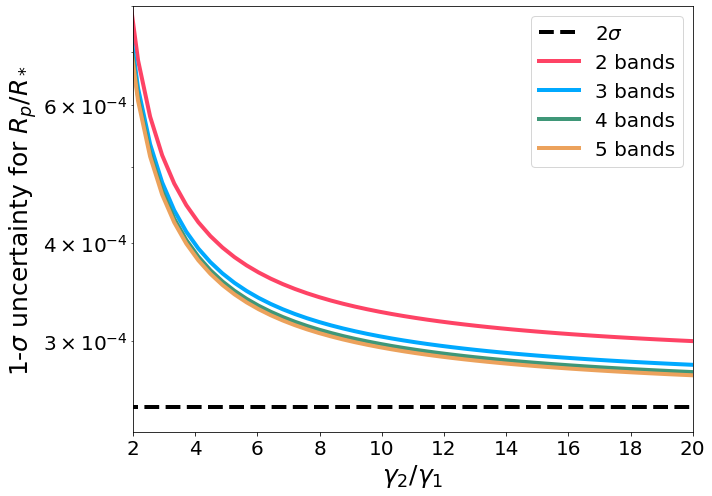

In [245]:
# plot the fisher information as a function of x 

figure = pl.figure(figsize=(10, 7))
pl.semilogy(x, 2*np.array(fish1)[:, 1], '--', color='k', label=r"$2\sigma$")
pl.semilogy(x, np.array(fish2)[:, 1], '-', color=red, label="2 bands")
pl.semilogy(x, np.array(fish3)[:, 1], '-', color=blue, label="3 bands")
pl.semilogy(x, np.array(fish4)[:, 1], '-', color=green, label="4 bands")
pl.semilogy(x, np.array(fish5)[:, 1], '-', color=yellow, label="5 bands")

pl.legend()
#pl.ylim(0, 1)
pl.xlim(2, 20)
pl.ylim(2.3e-4, 8e-4)
pl.xlabel(r"$\gamma_2/\gamma_1$")
pl.ylabel(r"1-$\sigma$ uncertainty for $R_p/R_*$")
pl.tight_layout()
pl.savefig("/Users/tgordon/Desktop/fixed.pdf")

In [247]:
fish1[:, 1]

TypeError: list indices must be integers or slices, not tuple

$\sum_{i=1}^N \gamma_i^2 = (\gamma_1^2 + \gamma_1 \gamma_2 + \gamma_2^2)/3$

$\sum_{i=1}^N \gamma_i = N^{1/2} (\gamma_1 + \gamma_2) / 2$

In [203]:
def sig_ratio(L1, L2):
    numerator = ((L1 + L2) ** 2) / 4
    denominator = 1 + ((L1 - L2) ** 2) / 12 
    return 1 + numerator / denominator

In [230]:
alpha2/alpha1

array([ 1.        ,  1.3877551 ,  1.7755102 ,  2.16326531,  2.55102041,
        2.93877551,  3.32653061,  3.71428571,  4.10204082,  4.48979592,
        4.87755102,  5.26530612,  5.65306122,  6.04081633,  6.42857143,
        6.81632653,  7.20408163,  7.59183673,  7.97959184,  8.36734694,
        8.75510204,  9.14285714,  9.53061224,  9.91836735, 10.30612245,
       10.69387755, 11.08163265, 11.46938776, 11.85714286, 12.24489796,
       12.63265306, 13.02040816, 13.40816327, 13.79591837, 14.18367347,
       14.57142857, 14.95918367, 15.34693878, 15.73469388, 16.12244898,
       16.51020408, 16.89795918, 17.28571429, 17.67346939, 18.06122449,
       18.44897959, 18.83673469, 19.2244898 , 19.6122449 , 20.        ])

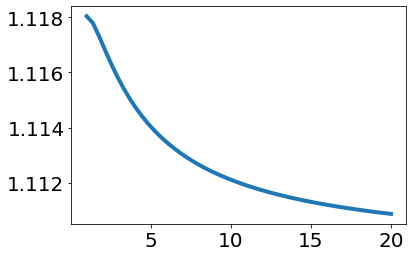

In [238]:
y = [sig_ratio(a1, a2) for (a1, a2) in zip(alpha1, alpha2)]
pl.plot(alpha2/alpha1, np.sqrt(y))

$\sigma_{poly}^2/\sigma_{mono}^2  = (1 + (\gamma_1^2 + \gamma_1 \gamma_2 + \gamma_2^2)/3)/
(1+(\gamma_1+\gamma_2)^2/12 - \gamma_1\gamma_2/6) / (1+ (\gamma_1+\gamma_2)^2/4)$

In [14]:
def sig_ratio_infinity(r, Fmin, Lmin, Lmax):
    Fmax = r*Fmin
    m = (Fmax - Fmin) / (Lmax - Lmin)
    int1_func = lambda l: ((Fmin + m * l) ** 2) / (2*m)
    int2_func = lambda l: ((Fmin + m * l) ** 3) / (3*m)
    int1 = int1_func(Lmax) - int1_func(Lmin)
    int2 = int2_func(Lmax) - int2_func(Lmin)
    return int2 / (int2 - ((int1 ** 2) / (Lmax - Lmin)))

In [60]:
r = np.linspace(1, 10, 100)
y = np.array([sig_ratio_infinity(r, 1, 10, 20) for r in r])

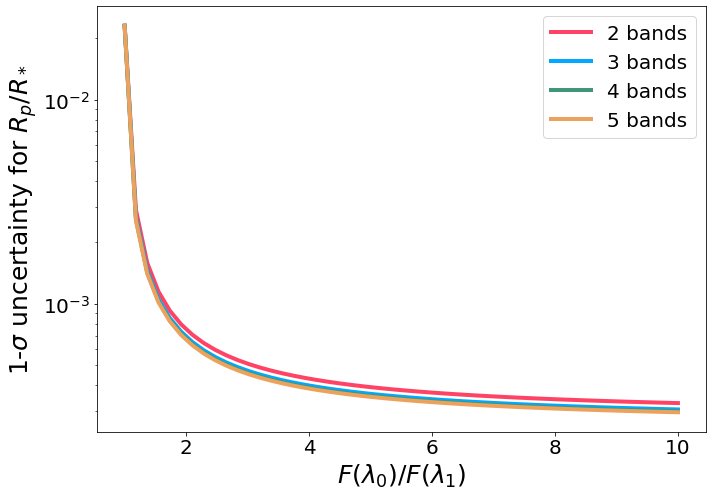

In [64]:
figure = pl.figure(figsize=(10, 7))
#pl.semilogy(x, np.sqrt(2)*np.array(fish1)[:, 1], '--', color='k', label=r"$\sqrt{2}\sigma$")
pl.semilogy(x, np.array(fish2)[:, 1], '-', color=red, label="2 bands")
pl.semilogy(x, np.array(fish3)[:, 1], '-', color=blue, label="3 bands")
pl.semilogy(x, np.array(fish4)[:, 1], '-', color=green, label="4 bands")
pl.semilogy(x, np.array(fish5)[:, 1], '-', color=yellow, label="5 bands")

pl.legend()
#pl.ylim(0, 1)
#pl.xlim(2, 10)
#pl.ylim(2.8e-4, 8e-4)
pl.xlabel(r"$F(\lambda_0)/F(\lambda_1)$")
pl.ylabel(r"1-$\sigma$ uncertainty for $R_p/R_*$")
pl.tight_layout()
pl.savefig("/Users/tgordon/Desktop/fixed.pdf")